In [43]:
# Fetch data ,
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data;

mkdir: cannot create directory ‘/data’: File exists
--2024-03-05 13:33:04--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.98.216, 16.182.109.168, 52.217.163.248, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.98.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.3’

train-test-data.zip 100%[===================>] 322.93M  28.7MB/s    in 8.8s    

2024-03-05 13:33:13 (36.9 MB/s) - ‘/data/train-test-data.zip.3’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


In [44]:
import random
import numpy as np
from PIL import Image
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from collections import OrderedDict
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as I
from torchvision import models
from torch.autograd import Variable
import torch
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
import torch.optim as optim
from tqdm.notebook import tqdm as tqdm_notebook
%load_ext autoreload
%autoreload 2
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:

class FacialKeypointsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.key_pts_frame = pd.read_csv(csv_file, index_col=0)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.key_pts_frame)
    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir, self.key_pts_frame.index[idx])
        image = mpimg.imread(image_name)
        if image.shape[2] == 4:
            image = image[:, :, 0:3]
        key_pts = self.key_pts_frame.iloc[idx, :].values
        key_pts = key_pts.astype("float").reshape(-1, 2)
        sample = {"image": image, "keypoints": key_pts}
        if self.transform:
            sample = self.transform(sample)
        return sample


In [46]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 4)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(p=0.1)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(p=0.2)
        self.conv3 = nn.Conv2d(64, 128, 2)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(p=0.3)
        self.conv4 = nn.Conv2d(128, 256, 1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.dropout4 = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(13 * 13 * 256, 1000)
        self.bn5 = nn.BatchNorm1d(1000)
        self.dropout5 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(1000, 1000)
        self.bn6 = nn.BatchNorm1d(1000)
        self.dropout6 = nn.Dropout(p=0.6)
        self.fc3 = nn.Linear(1000, 136)
        I.xavier_uniform_(self.fc1.weight.data)
        I.xavier_uniform_(self.fc2.weight.data)
        I.xavier_uniform_(self.fc3.weight.data)
    def forward(self, x):
        x = self.dropout1(self.pool1(F.elu(self.bn1(self.conv1(x)))))
        x = self.dropout2(self.pool2(F.elu(self.bn2(self.conv2(x)))))
        x = self.dropout3(self.pool3(F.elu(self.bn3(self.conv3(x)))))
        x = self.dropout4(self.pool4(F.elu(self.bn4(self.conv4(x)))))
        x = x.view(x.size(0), -1)
        x = self.dropout5(F.elu(self.bn5(self.fc1(x))))
        x = self.dropout6(F.elu(self.bn6(self.fc2(x))))
        x = self.fc3(x)
        return x
class NaimishNet(nn.Module):
    def __init__(
        self,
        image_size,
        output_size=136,
        kernels=(5, 5, 5, 5),
        out_channels=(32, 64, 128, 256),
        dropout_p=(0, 0, 0, 0, 0, 0),
        use_padding=True,
        use_maxp=True,
    ):
        super(NaimishNet, self).__init__()
        self.use_padding = use_padding
        if self.use_padding:
            self.padding = [int((k - 1) / 2) for k in kernels]
        else:
            self.padding = [0, 0, 0, 0]
        last_maxp_size = image_size
        for idx, val in enumerate(kernels):
            if self.use_padding:
                last_maxp_size = last_maxp_size // 2
            else:
                last_maxp_size = (last_maxp_size - (val - 1)) // 2
        last_maxp_size = out_channels[3] * last_maxp_size * last_maxp_size
        self.conv1 = nn.Sequential(
            OrderedDict(
                [
                    (
                        "conv1",
                        nn.Conv2d(
                            1,
                            out_channels[0],
                            kernel_size=kernels[0],
                            padding=self.padding[0],
                        ),
                    ),
                    ("relu1", nn.ReLU()),
                ]
            )
        )
        if use_maxp:
            self.maxp1 = nn.Sequential(
                OrderedDict(
                    [
                        ("maxp1", nn.MaxPool2d(2, 2)),
                        ("dropout1", nn.Dropout(dropout_p[0])),
                        ("bachnorm1", nn.BatchNorm2d(out_channels[0])),
                    ]
                )
            )
        else:
            self.maxp1 = nn.Sequential(
                OrderedDict(
                    [
                        ("maxp1", nn.AvgPool2d(2, 2)),
                        ("dropout1", nn.Dropout(dropout_p[0])),
                        ("bachnorm1", nn.BatchNorm2d(out_channels[0])),
                    ]
                )
            )
        self.conv2 = nn.Sequential(
            OrderedDict(
                [
                    (
                        "conv2",
                        nn.Conv2d(
                            out_channels[0],
                            out_channels[1],
                            kernel_size=kernels[1],
                            padding=self.padding[1],
                        ),
                    ),
                    ("relu2", nn.ReLU()),
                ]
            )
        )
        if use_maxp:
            self.maxp2 = nn.Sequential(
                OrderedDict(
                    [
                        ("maxp2", nn.MaxPool2d(2, 2)),
                        ("dropout2", nn.Dropout(dropout_p[1])),
                        ("bachnorm2", nn.BatchNorm2d(out_channels[1])),
                    ]
                )
            )
        else:
            self.maxp2 = nn.Sequential(
                OrderedDict(
                    [
                        ("maxp2", nn.AvgPool2d(2, 2)),
                        ("dropout2", nn.Dropout(dropout_p[1])),
                        ("bachnorm2", nn.BatchNorm2d(out_channels[1])),
                    ]
                )
            )
        self.conv3 = nn.Sequential(
            OrderedDict(
                [
                    (
                        "conv3",
                        nn.Conv2d(
                            out_channels[1],
                            out_channels[2],
                            kernel_size=kernels[2],
                            padding=self.padding[2],
                        ),
                    ),
                    ("relu3", nn.ReLU()),
                ]
            )
        )
        if use_maxp:
            self.maxp3 = nn.Sequential(
                OrderedDict(
                    [
                        ("maxp3", nn.MaxPool2d(2, 2)),
                        ("dropout3", nn.Dropout(dropout_p[2])),
                        ("bachnorm3", nn.BatchNorm2d(out_channels[2])),
                    ]
                )
            )
        else:
            self.maxp3 = nn.Sequential(
                OrderedDict(
                    [
                        ("maxp3", nn.AvgPool2d(2, 2)),
                        ("dropout3", nn.Dropout(dropout_p[2])),
                        ("bachnorm3", nn.BatchNorm2d(out_channels[2])),
                    ]
                )
            )
        self.conv4 = nn.Sequential(
            OrderedDict(
                [
                    (
                        "conv4",
                        nn.Conv2d(
                            out_channels[2],
                            out_channels[3],
                            kernel_size=kernels[3],
                            padding=self.padding[3],
                        ),
                    ),
                    ("relu4", nn.ReLU()),
                ]
            )
        )
        if use_maxp:
            self.maxp4 = nn.Sequential(
                OrderedDict(
                    [
                        ("maxp4", nn.MaxPool2d(2, 2)),
                        ("dropout4", nn.Dropout(dropout_p[3])),
                        ("bachnorm4", nn.BatchNorm2d(out_channels[3])),
                    ]
                )
            )
        else:
            self.maxp4 = nn.Sequential(
                OrderedDict(
                    [
                        ("maxp4", nn.AvgPool2d(2, 2)),
                        ("dropout4", nn.Dropout(dropout_p[3])),
                        ("bachnorm4", nn.BatchNorm2d(out_channels[3])),
                    ]
                )
            )
        self.fc1 = nn.Sequential(
            OrderedDict(
                [
                    ("fc1", nn.Linear(last_maxp_size, 1024)),
                    ("relu5", nn.ReLU()),
                    ("dropout5", nn.Dropout(dropout_p[4])),
                    ("bachnorm5", nn.BatchNorm1d(1024)),
                ]
            )
        )
        self.fc2 = nn.Sequential(
            OrderedDict(
                [
                    ("fc2", nn.Linear(1024, 1024)),
                    ("relu6", nn.ReLU()),
                    ("dropout6", nn.Dropout(dropout_p[5])),
                    ("bachnorm6", nn.BatchNorm1d(1024)),
                ]
            )
        )
        self.fc3 = nn.Sequential(
            OrderedDict([("fc3", nn.Linear(1024, output_size))])
        )
    def forward(self, x):
        out = self.conv1(x)
        out = self.maxp1(out)
        out = self.conv2(out)
        out = self.maxp2(out)
        out = self.conv3(out)
        out = self.maxp3(out)
        out = self.conv4(out)
        out = self.maxp4(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
    def __str__(self):
        pretty_net_str = ""
        for layer_name in self._modules:
            pretty_net_str += f"{layer_name}:\n"
            for items in getattr(self, layer_name):
                pretty_net_str += f"{items}\n"
            pretty_net_str += "\n"
        return pretty_net_str
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Sequential(
            OrderedDict(
                [
                    ("conv1", nn.Conv2d(1, 64, kernel_size=5, padding=2)),
                    ("relu1", nn.ReLU()),
                ]
            )
        )
        self.maxp1 = nn.Sequential(OrderedDict([("maxp1", nn.MaxPool2d(2, 2))]))
        self.conv2 = nn.Sequential(
            OrderedDict(
                [
                    ("conv2", nn.Conv2d(64, 128, kernel_size=5, padding=2)),
                    ("relu2", nn.ReLU()),
                ]
            )
        )
        self.maxp2 = nn.Sequential(OrderedDict([("maxp2", nn.MaxPool2d(2, 2))]))
        self.fc1 = nn.Sequential(
            OrderedDict([("fc1", nn.Linear(128 * 56 * 56, 544)), ("relu3", nn.ReLU())])
        )
        self.fc2 = nn.Sequential(
            OrderedDict([("fc2", nn.Linear(544, 272)), ("relu4", nn.ReLU())])
        )
        self.fc3 = nn.Sequential(OrderedDict([("fc3", nn.Linear(272, 136))]))
    def forward(self, x):
        out = self.conv1(x)
        out = self.maxp1(out)
        out = self.conv2(out)
        out = self.maxp2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
    def __str__(self):
        pretty_net_str = ""
        for layer_name in self._modules:
            pretty_net_str += f"{layer_name}:\n"
            for items in getattr(self, layer_name):
                pretty_net_str += f"{items}\n"
            pretty_net_str += "\n"
        return pretty_net_str
class VGG11Conv5One(nn.Module):
    def __init__(self):
        super(VGG11Conv5One, self).__init__()
        vgg11 = models.vgg11(pretrained=True).features
        for param in vgg11.parameters():
            param.requires_grad_(False)
        modules = list(vgg11.children())[:-3]
        self.features = nn.Sequential(*modules)
        self.keypoints_estimator = nn.Sequential(
            nn.Linear(100352, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(1024, 136),
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.keypoints_estimator(x)
        return x
class VGG11Maxp4(nn.Module):
    def __init__(self):
        super(VGG11Maxp4, self).__init__()
        vgg11 = models.vgg11(pretrained=True).features
        for param in vgg11.parameters():
            param.requires_grad_(False)
        modules = list(vgg11.children())[:-5]
        self.features = nn.Sequential(*modules)
        self.keypoints_estimator = nn.Sequential(
            nn.Linear(100352, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(1024, 136),
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.keypoints_estimator(x)
        return x
class VGG11Conv4Two(nn.Module):
    def __init__(self):
        super(VGG11Conv4Two, self).__init__()
        vgg11 = models.vgg11(pretrained=True).features
        for param in vgg11.parameters():
            param.requires_grad_(False)
        modules = list(vgg11.children())[:-6]
        self.features = nn.Sequential(*modules)
        self.keypoints_estimator = nn.Sequential(
            nn.Linear(401408, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(1024, 136),
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.keypoints_estimator(x)
        return x
class VGG11Conv4One(nn.Module):
    def __init__(self):
        super(VGG11Conv4One, self).__init__()
        vgg11 = models.vgg11(pretrained=True).features
        for param in vgg11.parameters():
            param.requires_grad_(False)
        modules = list(vgg11.children())[:-8]
        self.features = nn.Sequential(*modules)
        self.keypoints_estimator = nn.Sequential(
            nn.Linear(401408, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(1024, 136),
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.keypoints_estimator(x)
        return x
class VGG11Maxp3(nn.Module):
    def __init__(self):
        super(VGG11Maxp3, self).__init__()
        vgg11 = models.vgg11(pretrained=True).features
        for param in vgg11.parameters():
            param.requires_grad_(False)
        modules = list(vgg11.children())[:-10]
        self.features = nn.Sequential(*modules)
        self.keypoints_estimator = nn.Sequential(
            nn.Linear(200704, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(1024, 136),
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.keypoints_estimator(x)
        return x
class VGG11Maxp2(nn.Module):
    def __init__(self):
        super(VGG11Maxp2, self).__init__()
        vgg11 = models.vgg11(pretrained=True).features
        for param in vgg11.parameters():
            param.requires_grad_(False)
        modules = list(vgg11.children())[:-15]
        self.features = nn.Sequential(*modules)
        self.keypoints_estimator = nn.Sequential(
            nn.Linear(401408, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(1024, 136),
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.keypoints_estimator(x)
        return x
class Resnet18(nn.Module):
    def __init__(self):
        super(Resnet18, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        n_inputs = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(n_inputs, 136)
    def forward(self, x):
        x = self.resnet18(x)
        return x
class Resnet18Grayscale(nn.Module):
    def __init__(self):
        super(Resnet18Grayscale, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.conv1 = nn.Conv2d(
            1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        n_inputs = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(n_inputs, 136)
    def forward(self, x):
        x = self.resnet18(x)
        return x
class Resnet50(nn.Module):
    def __init__(self):
        super(Resnet50, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        n_inputs = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(n_inputs, 136)
    def forward(self, x):
        x = self.resnet50(x)
        return x
class Resnet50Grayscale(nn.Module):
    def __init__(self):
        super(Resnet50Grayscale, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        self.resnet50.conv1 = nn.Conv2d(
            1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        n_inputs = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(n_inputs, 136)
    def forward(self, x):
        x = self.resnet50(x)
        return x
class SqueezenetGrayscale(nn.Module):
    def __init__(self):
        super(SqueezenetGrayscale, self).__init__()
        squeezenet1_1 = models.squeezenet1_1(pretrained=True).features
        modules = list(squeezenet1_1.children())
        modules[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
        self.features = nn.Sequential(*modules)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Conv2d(512, 136, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=13, stride=1, padding=0),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.view(x.size(0), 136)


In [47]:

class Normalize(object):
    def __init__(self, color=False):
        self.color = color
    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)
        if not self.color:
            image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image_copy = image_copy / 255.0
        key_pts_copy = (key_pts_copy - image.shape[0] / 2) / (image.shape[0] / 4)
        return {"image": image_copy, "keypoints": key_pts_copy}
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = cv2.resize(image, (new_w, new_h))
        key_pts = key_pts * [new_w / w, new_h / h]
        return {"image": img, "keypoints": key_pts}
class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        image = image[top : top + new_h, left : left + new_w]
        key_pts = key_pts - [left, top]
        return {"image": image, "keypoints": key_pts}
class FaceCrop(object):
    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]
        image_copy = np.copy(image)
        h, w = image.shape[:2]
        x_max = 0
        x_min = 10000
        y_max = 0
        y_min = 10000
        for coord in key_pts:
            if coord[0] > x_max:
                if coord[0] >= w:
                    x_max = w
                else:
                    x_max = coord[0]
            if coord[0] < x_min:
                if coord[0] < 0:
                    x_min = 0
                else:
                    x_min = coord[0]
            if coord[1] > y_max:
                if coord[1] >= h:
                    y_max = h
                else:
                    y_max = coord[1]
            if coord[1] < y_min:
                if coord[1] < 0:
                    y_min = 0
                else:
                    y_min = coord[1]
        x = int(x_min)
        y = int(y_min)
        new_h = int(y_max - y_min)
        new_w = int(x_max - x_min)
        if new_h > new_w:
            new_w = new_h
        else:
            new_h = new_w
        randsize1 = [2, 70]
        randsize2 = [2, 30]
        randsize3 = [1, 10]
        padding_x_1 = 0
        padding_x_2 = 0
        padding_y_1 = 0
        padding_y_2 = 0
        padding_size_x_1 = random.randint(randsize1[0], randsize1[1])
        padding_size_x_2 = random.randint(randsize1[0], randsize1[1])
        padding_size_y_1 = random.randint(randsize1[0], randsize1[1])
        padding_size_y_2 = random.randint(randsize1[0], randsize1[1])
        if (
            y - padding_size_y_1 > 0
            and x - padding_size_x_1 > 0
            and x + new_w + padding_size_x_2 < w
            and y + new_h + padding_size_y_2 < h
        ):
            padding_x_1 = padding_size_x_1
            padding_x_2 = padding_size_x_2
            padding_y_1 = padding_size_y_1
            padding_y_2 = padding_size_y_2
        else:
            padding_size_x_1 = random.randint(randsize2[0], randsize2[1])
            padding_size_x_2 = random.randint(randsize2[0], randsize2[1])
            padding_size_y_1 = random.randint(randsize2[0], randsize2[1])
            padding_size_y_2 = random.randint(randsize2[0], randsize2[1])
            if (
                y - padding_size_y_1 > 0
                and x - padding_size_x_1 > 0
                and x + new_w + padding_size_x_2 < w
                and y + new_h + padding_size_y_2 < h
            ):
                padding_x_1 = padding_size_x_1
                padding_x_2 = padding_size_x_2
                padding_y_1 = padding_size_y_1
                padding_y_2 = padding_size_y_2
            else:
                padding_size_x_1 = random.randint(randsize3[0], randsize3[1])
                padding_size_x_2 = random.randint(randsize3[0], randsize3[1])
                padding_size_y_1 = random.randint(randsize3[0], randsize3[1])
                padding_size_y_2 = random.randint(randsize3[0], randsize3[1])
                if (
                    y - padding_size_y_1 > 0
                    and x - padding_size_x_1 > 0
                    and x + new_w + padding_size_x_2 < w
                    and y + new_h + padding_size_y_2 < h
                ):
                    padding_x_1 = padding_size_x_1
                    padding_x_2 = padding_size_x_2
                    padding_y_1 = padding_size_y_1
                    padding_y_2 = padding_size_y_2
        image_copy = image_copy[
            y - padding_y_1 : y + new_h + padding_y_2,
            x - padding_x_1 : x + new_w + padding_x_2,
        ]
        key_pts = key_pts - [x - padding_x_1, y - padding_y_1]
        return {"image": image_copy, "keypoints": key_pts}
class FaceCropTight(object):
    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]
        image_copy = np.copy(image)
        h, w = image.shape[:2]
        x_max = 0
        x_min = 10000
        y_max = 0
        y_min = 10000
        for coord in key_pts:
            if coord[0] > x_max:
                if coord[0] >= w:
                    x_max = w
                else:
                    x_max = coord[0]
            if coord[0] < x_min:
                if coord[0] < 0:
                    x_min = 0
                else:
                    x_min = coord[0]
            if coord[1] > y_max:
                if coord[1] >= h:
                    y_max = h
                else:
                    y_max = coord[1]
            if coord[1] < y_min:
                if coord[1] < 0:
                    y_min = 0
                else:
                    y_min = coord[1]
        x = int(x_min)
        y = int(y_min)
        new_h = int(y_max - y_min)
        new_w = int(x_max - x_min)
        if new_h > new_w:
            new_w = new_h
        else:
            new_h = new_w
        randsize1 = [5, 10]
        padding_x_1 = 0
        padding_x_2 = 0
        padding_y_1 = 0
        padding_y_2 = 0
        padding_size_x_1 = random.randint(randsize1[0], randsize1[1])
        padding_size_x_2 = random.randint(randsize1[0], randsize1[1])
        padding_size_y_1 = random.randint(randsize1[0], randsize1[1])
        padding_size_y_2 = random.randint(randsize1[0], randsize1[1])
        if (
            y - padding_size_y_1 > 0
            and x - padding_size_x_1 > 0
            and x + new_w + padding_size_x_2 < w
            and y + new_h + padding_size_y_2 < h
        ):
            padding_x_1 = padding_size_x_1
            padding_x_2 = padding_size_x_2
            padding_y_1 = padding_size_y_1
            padding_y_2 = padding_size_y_2
        image_copy = image_copy[
            y - padding_y_1 : y + new_h + padding_y_2,
            x - padding_x_1 : x + new_w + padding_x_2,
        ]
        key_pts = key_pts - [x - padding_x_1, y - padding_y_1]
        return {"image": image_copy, "keypoints": key_pts}
class ToTensor(object):
    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]
        if len(image.shape) == 2:
            image = image.reshape(image.shape[0], image.shape[1], 1)
        image = image.transpose((2, 0, 1))
        return {
            "image": torch.from_numpy(image),
            "keypoints": torch.from_numpy(key_pts),
        }
class Random90DegFlip(object):
    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)
        if random.choice([0, 1]) < 0.25:
            image_copy = np.rot90(image_copy, 1)
            image_copy = np.flipud(image_copy)
            key_pts_copy = np.fliplr(key_pts_copy)
        return {"image": image_copy, "keypoints": key_pts_copy}
class RandomGamma(object):
    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)
        image_copy = adjust_gamma(image_copy, gamma=random.uniform(0.8, 1.1))
        return {"image": image_copy, "keypoints": key_pts_copy}
class ColorJitter(object):
    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]
        color_jitter = transforms.ColorJitter(
            brightness=0.4,
            contrast=0.4,
            saturation=0.4,
        )
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)
        image_copy = color_jitter(Image.fromarray(image_copy))
        image_copy = np.array(image_copy)
        return {"image": image_copy, "keypoints": key_pts_copy}
def adjust_gamma(
    image, gamma=1.0
):
    inv_gamma = 1.0 / gamma
    table = np.array(
        [((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]
    ).astype("uint8")
    return cv2.LUT(image, table)
class RandomHorizontalFlip(object):
    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)
        key_pts_copy_2 = np.copy(key_pts_copy)
        if random.choice([0, 1]) <= 0.5:
            image_copy = np.fliplr(image_copy)
            key_pts_copy[:, 0] = -key_pts_copy[:, 0]
            key_pts_copy[:, 0] = key_pts_copy[:, 0] + image_copy.shape[1]
            key_pts_copy_2 = np.copy(key_pts_copy)
            key_pts_copy_2[16] = key_pts_copy[0]
            key_pts_copy_2[15] = key_pts_copy[1]
            key_pts_copy_2[14] = key_pts_copy[2]
            key_pts_copy_2[13] = key_pts_copy[3]
            key_pts_copy_2[12] = key_pts_copy[4]
            key_pts_copy_2[11] = key_pts_copy[5]
            key_pts_copy_2[10] = key_pts_copy[6]
            key_pts_copy_2[9] = key_pts_copy[7]
            key_pts_copy_2[8] = key_pts_copy[8]
            key_pts_copy_2[7] = key_pts_copy[9]
            key_pts_copy_2[6] = key_pts_copy[10]
            key_pts_copy_2[5] = key_pts_copy[11]
            key_pts_copy_2[4] = key_pts_copy[12]
            key_pts_copy_2[3] = key_pts_copy[13]
            key_pts_copy_2[2] = key_pts_copy[14]
            key_pts_copy_2[1] = key_pts_copy[15]
            key_pts_copy_2[0] = key_pts_copy[16]
            key_pts_copy_2[26] = key_pts_copy[17]
            key_pts_copy_2[25] = key_pts_copy[18]
            key_pts_copy_2[24] = key_pts_copy[19]
            key_pts_copy_2[23] = key_pts_copy[20]
            key_pts_copy_2[22] = key_pts_copy[21]
            key_pts_copy_2[21] = key_pts_copy[22]
            key_pts_copy_2[20] = key_pts_copy[23]
            key_pts_copy_2[19] = key_pts_copy[24]
            key_pts_copy_2[18] = key_pts_copy[25]
            key_pts_copy_2[17] = key_pts_copy[26]
            key_pts_copy_2[35] = key_pts_copy[31]
            key_pts_copy_2[34] = key_pts_copy[32]
            key_pts_copy_2[33] = key_pts_copy[33]
            key_pts_copy_2[32] = key_pts_copy[34]
            key_pts_copy_2[31] = key_pts_copy[35]
            key_pts_copy_2[45] = key_pts_copy[36]
            key_pts_copy_2[44] = key_pts_copy[37]
            key_pts_copy_2[43] = key_pts_copy[38]
            key_pts_copy_2[42] = key_pts_copy[39]
            key_pts_copy_2[47] = key_pts_copy[40]
            key_pts_copy_2[46] = key_pts_copy[41]
            key_pts_copy_2[39] = key_pts_copy[42]
            key_pts_copy_2[38] = key_pts_copy[43]
            key_pts_copy_2[37] = key_pts_copy[44]
            key_pts_copy_2[36] = key_pts_copy[45]
            key_pts_copy_2[41] = key_pts_copy[46]
            key_pts_copy_2[40] = key_pts_copy[47]
            key_pts_copy_2[54] = key_pts_copy[48]
            key_pts_copy_2[53] = key_pts_copy[49]
            key_pts_copy_2[52] = key_pts_copy[50]
            key_pts_copy_2[51] = key_pts_copy[51]
            key_pts_copy_2[50] = key_pts_copy[52]
            key_pts_copy_2[49] = key_pts_copy[53]
            key_pts_copy_2[48] = key_pts_copy[54]
            key_pts_copy_2[59] = key_pts_copy[55]
            key_pts_copy_2[58] = key_pts_copy[56]
            key_pts_copy_2[57] = key_pts_copy[57]
            key_pts_copy_2[56] = key_pts_copy[58]
            key_pts_copy_2[55] = key_pts_copy[59]
            key_pts_copy_2[64] = key_pts_copy[60]
            key_pts_copy_2[63] = key_pts_copy[61]
            key_pts_copy_2[62] = key_pts_copy[62]
            key_pts_copy_2[61] = key_pts_copy[63]
            key_pts_copy_2[60] = key_pts_copy[64]
            key_pts_copy_2[67] = key_pts_copy[65]
            key_pts_copy_2[66] = key_pts_copy[66]
            key_pts_copy_2[65] = key_pts_copy[67]
        return {"image": image_copy, "keypoints": key_pts_copy_2}
class Rotate(object):
    def __init__(self, rotation):
        self.rotation = rotation
    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)
        rows = image.shape[0]
        cols = image.shape[1]
        M = cv2.getRotationMatrix2D((rows / 2, cols / 2), 90, 1)
        image_copy = cv2.warpAffine(image_copy, M, (cols, rows))
        key_pts_copy = key_pts_copy.reshape((1, 136))
        new_keypoints = np.zeros(136)
        for i in range(68):
            coord_idx = 2 * i
            old_coord = key_pts_copy[0][coord_idx : coord_idx + 2]
            new_coord = np.matmul(M, np.append(old_coord, 1))
            new_keypoints[coord_idx] += new_coord[0]
            new_keypoints[coord_idx + 1] += new_coord[1]
        new_keypoints = new_keypoints.reshape((68, 2))
        return {"image": image_copy, "keypoints": new_keypoints}
class RandomRotate(object):
    def __init__(self, rotation=30):
        self.rotation = rotation
    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)
        rows = image.shape[0]
        cols = image.shape[1]
        M = cv2.getRotationMatrix2D(
            (rows / 2, cols / 2), random.choice([-self.rotation, self.rotation]), 1
        )
        image_copy = cv2.warpAffine(image_copy, M, (cols, rows))
        key_pts_copy = key_pts_copy.reshape((1, 136))
        new_keypoints = np.zeros(136)
        for i in range(68):
            coord_idx = 2 * i
            old_coord = key_pts_copy[0][coord_idx : coord_idx + 2]
            new_coord = np.matmul(M, np.append(old_coord, 1))
            new_keypoints[coord_idx] += new_coord[0]
            new_keypoints[coord_idx + 1] += new_coord[1]
        new_keypoints = new_keypoints.reshape((68, 2))
        return {"image": image_copy, "keypoints": new_keypoints}
class NormalizeOriginal(object):
    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image_copy = image_copy / 255.0
        key_pts_copy = (key_pts_copy - 100) / 50.0
        return {"image": image_copy, "keypoints": key_pts_copy}


In [48]:
keypoints_csv_path = os.path.join("/data", "training_frames_keypoints.csv")
training_data_dir = os.path.join("/data", "training")

In [49]:
key_pts_frame = pd.read_csv(keypoints_csv_path, index_col=0)

In [50]:
key_pts_frame.head()

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,125.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,119.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,103.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,132.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,130.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [51]:
key_pts_frame.shape

(3462, 136)

In [52]:
n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, :].values
key_pts = key_pts.astype("float").reshape(-1, 2)

In [53]:
key_pts.shape

(68, 2)

In [54]:
print("Image name: ", image_name)
print("Landmarks shape: ", key_pts.shape)
print("First 4 key pts: {}".format(key_pts[:4]))

Image name:  45.0
Landmarks shape:  (68, 2)
First 4 key pts: [[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]]


In [55]:
print("Number of images: ", len(key_pts_frame))
print("Number of keypoints per image: ", len(key_pts))

Number of images:  3462
Number of keypoints per image:  68


In [56]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker=".", c="m")

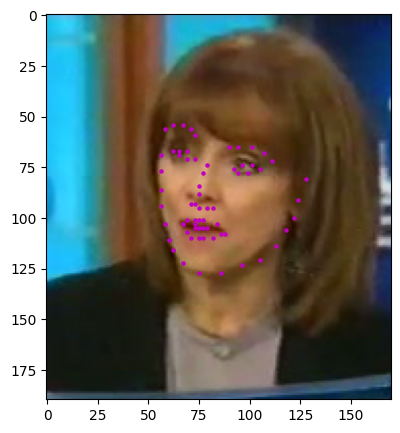

In [57]:
n = 2
image_name = key_pts_frame.index[n]
key_pts = key_pts_frame.iloc[n, :].values
key_pts = key_pts.astype("float").reshape(-1, 2)
plt.figure(figsize=(5, 5))
show_keypoints(mpimg.imread(os.path.join(training_data_dir, image_name)), key_pts)
plt.show()

In [58]:
class FacialKeypointsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.key_pts_frame = pd.read_csv(csv_file, index_col=0)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.key_pts_frame)
    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir, self.key_pts_frame.index[idx])
        image = mpimg.imread(image_name)
        if image.shape[2] == 4:
            image = image[:, :, 0:3]
        key_pts = self.key_pts_frame.iloc[idx, :].values
        key_pts = key_pts.astype("float").reshape(-1, 2)
        sample = {"image": image, "keypoints": key_pts}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [59]:
face_dataset = FacialKeypointsDataset(
    csv_file=keypoints_csv_path, root_dir=training_data_dir
)
print("Length of dataset: ", len(face_dataset))

Length of dataset:  3462


0 (104, 89, 3) (68, 2)
1 (300, 250, 3) (68, 2)
2 (113, 110, 3) (68, 2)


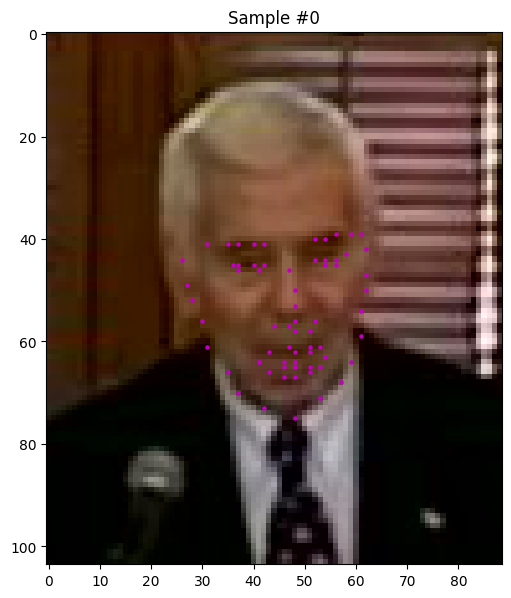

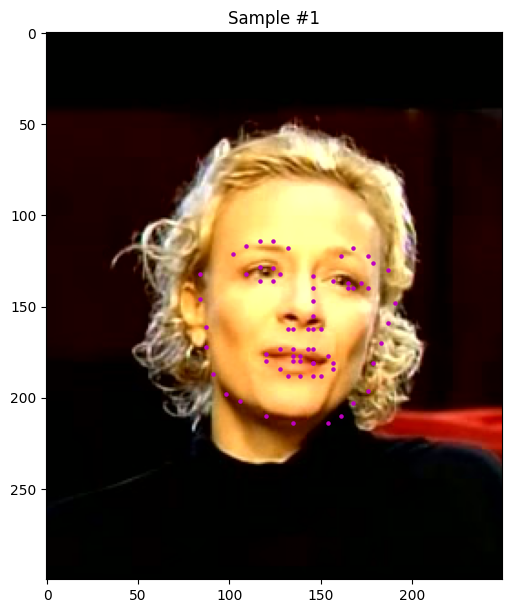

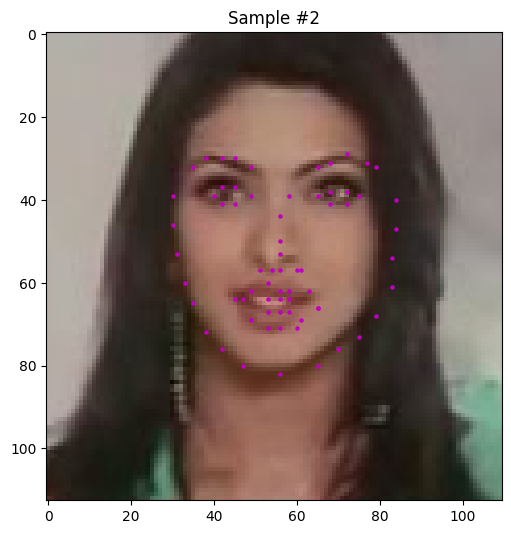

In [60]:
num_to_display = 3
for i in range(num_to_display):
    fig = plt.figure(figsize=(20, 10))
    rand_i = np.random.randint(0, len(face_dataset))
    sample = face_dataset[rand_i]  # call __getitem__
    print(i, sample["image"].shape, sample["keypoints"].shape)
    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title("Sample #{}".format(i))
    show_keypoints(sample["image"], sample["keypoints"])

In [61]:
class Normalize(object):
    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image_copy = image_copy / 255.0
        key_pts_copy = (key_pts_copy - 100) / 50.0
        return {"image": image_copy, "keypoints": key_pts_copy}
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = cv2.resize(image, (new_w, new_h))
        key_pts = key_pts * [new_w / w, new_h / h]
        return {"image": img, "keypoints": key_pts}
class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        image = image[top : top + new_h, left : left + new_w]
        key_pts = key_pts - [left, top]
        return {"image": image, "keypoints": key_pts}
class ToTensor(object):
    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]
        if len(image.shape) == 2:
            image = image.reshape(image.shape[0], image.shape[1], 1)
        image = image.transpose((2, 0, 1))
        return {
            "image": torch.from_numpy(image),
            "keypoints": torch.from_numpy(key_pts),
        }

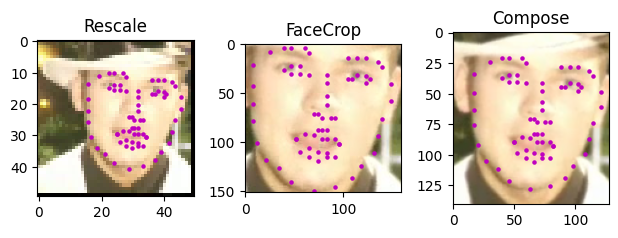

In [62]:
face_cascade = cv2.CascadeClassifier(
    "detector_architectures/haarcascade_frontalface_default.xml"
)
rescale = Rescale(50)
crop = FaceCrop()
composed = transforms.Compose([Rescale(250), FaceCrop(), Rescale(128)])
test_num = 200
sample = face_dataset[test_num]
fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
    transformed_sample = tx(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample["image"], transformed_sample["keypoints"])
plt.show()

In [63]:
data_transform = transforms.Compose(
    [Rescale(250), RandomCrop(224), Normalize(), ToTensor()]
)
transformed_dataset = FacialKeypointsDataset(
    csv_file=keypoints_csv_path,
    root_dir=training_data_dir,
    transform=data_transform,
)

In [64]:
print("Number of images: ", len(transformed_dataset))
for i in range(5):
    sample = transformed_dataset[i]
    print(i, sample["image"].size(), sample["keypoints"].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])
4 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [65]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [66]:
data_transform = transforms.Compose(
    [Rescale(250), RandomCrop(224), NormalizeOriginal(), ToTensor()]
)
assert data_transform is not None, "Define a data_transform"

In [67]:
training_keypoints_csv_path = os.path.join("/data", "training_frames_keypoints.csv")
training_data_dir = os.path.join("/data", "training")
test_keypoints_csv_path = os.path.join("/data", "test_frames_keypoints.csv")
test_data_dir = os.path.join("/data", "test")

In [68]:
transformed_dataset = FacialKeypointsDataset(
    csv_file=training_keypoints_csv_path,
    root_dir=training_data_dir,
    transform=data_transform,
)
print("Number of images: ", len(transformed_dataset))
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample["image"].size(), sample["keypoints"].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [69]:
batch_size = 64
train_loader = DataLoader(
    transformed_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [70]:
test_dataset = FacialKeypointsDataset(
    csv_file=test_keypoints_csv_path, root_dir=test_data_dir, transform=data_transform
)

In [71]:
batch_size = 16
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [72]:
def net_sample_output(model, test_loader):
    for i, sample in enumerate(test_loader):
        images = sample["image"]
        key_pts = sample["keypoints"]
        images = images.type(torch.FloatTensor)
        output_pts = model(images)
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        if i == 0:
            return (
                images,
                output_pts,
                key_pts,
            )

In [73]:
test_images, test_outputs, gt_pts = net_sample_output(net, test_loader)
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


In [74]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    plt.imshow(image, cmap="gray")
    plt.scatter(
        predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker=".", c="m"
    )
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker=".", c="g")

In [75]:
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    plt.figure(figsize=(20, 10))
    for i in range(batch_size):
        ax = plt.subplot(batch_size // 5, 5, i + 1)
        image = test_images[i].data
        image = image.numpy()
        image = np.transpose(
            image, (1, 2, 0)
        )
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        predicted_key_pts = predicted_key_pts * 50.0 + 100
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]
            ground_truth_pts = ground_truth_pts * 50.0 + 100
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
        plt.axis("off")
    plt.show()

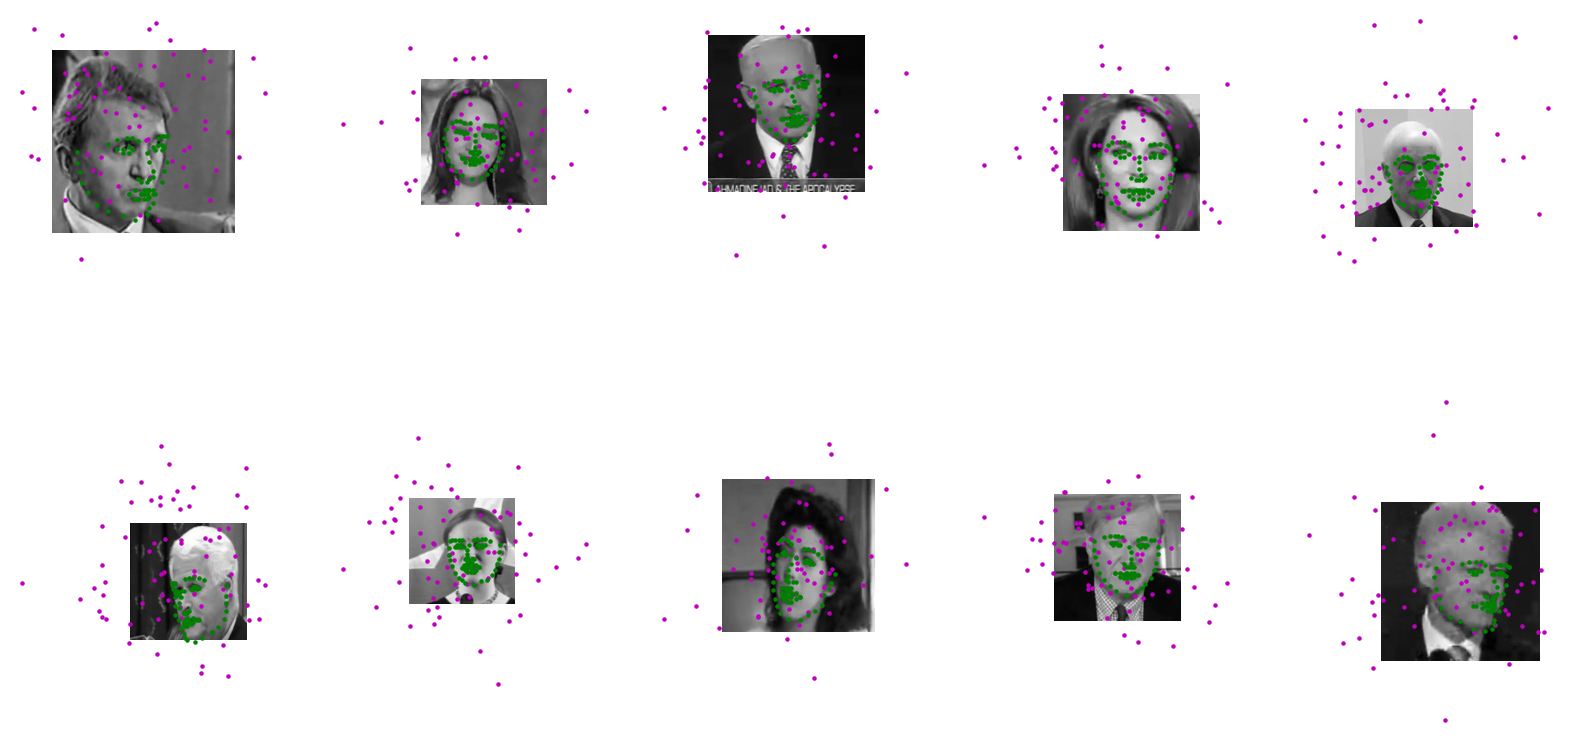

In [76]:
visualize_output(test_images, test_outputs, gt_pts)

In [77]:
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [82]:
def train_net(n_epochs):
    losses = []
    net.train()
    for epoch in tqdm_notebook(range(n_epochs), desc="training"):
        running_loss = 0.0
        batch_i = 0
        for data in tqdm_notebook(train_loader, desc="epoch {}".format(epoch)):
            images = data["image"]
            key_pts = data["keypoints"]
            key_pts = key_pts.view(key_pts.size(0), -1)
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            output_pts = net(images)
            loss = criterion(output_pts, key_pts)
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if batch_i % 10 == 9:
                print(
                    "Epoch: {}, Batch: {}, Avg. Loss: {}".format(
                        epoch + 1, batch_i + 1, running_loss / batch_size
                    )
                )
                running_loss = 0.0
            batch_i += 1
    return losses
    print("Finished Training")

In [ ]:
import tqdm
n_epochs = 14
losses = train_net(n_epochs)

training:   0%|          | 0/14 [00:00<?, ?it/s]

epoch 0:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 1, Batch: 10, Avg. Loss: 0.30042698979377747
Epoch: 1, Batch: 20, Avg. Loss: 0.27934349328279495
Epoch: 1, Batch: 30, Avg. Loss: 0.2499605305492878
Epoch: 1, Batch: 40, Avg. Loss: 0.23279747553169727
Epoch: 1, Batch: 50, Avg. Loss: 0.21049699187278748


epoch 1:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 2, Batch: 10, Avg. Loss: 0.2035996038466692
Epoch: 2, Batch: 20, Avg. Loss: 0.19068072736263275
Epoch: 2, Batch: 30, Avg. Loss: 0.1715904613956809
Epoch: 2, Batch: 40, Avg. Loss: 0.15937273669987917
Epoch: 2, Batch: 50, Avg. Loss: 0.1576603027060628


epoch 2:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 3, Batch: 10, Avg. Loss: 0.1821027249097824
Epoch: 3, Batch: 20, Avg. Loss: 0.16455443296581507
Epoch: 3, Batch: 30, Avg. Loss: 0.14421363081783056
Epoch: 3, Batch: 40, Avg. Loss: 0.14019599556922913
Epoch: 3, Batch: 50, Avg. Loss: 0.1309230113402009


epoch 3:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 4, Batch: 10, Avg. Loss: 0.13486145716160536
Epoch: 4, Batch: 20, Avg. Loss: 0.12423191964626312
Epoch: 4, Batch: 30, Avg. Loss: 0.11618930380791426
Epoch: 4, Batch: 40, Avg. Loss: 0.1056961752474308
Epoch: 4, Batch: 50, Avg. Loss: 0.11631775740534067


epoch 4:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 5, Batch: 10, Avg. Loss: 0.10840882174670696
Epoch: 5, Batch: 20, Avg. Loss: 0.10662616975605488
Epoch: 5, Batch: 30, Avg. Loss: 0.10119422897696495
Epoch: 5, Batch: 40, Avg. Loss: 0.0996081754565239
Epoch: 5, Batch: 50, Avg. Loss: 0.0899966605938971


epoch 5:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 6, Batch: 10, Avg. Loss: 0.09273159643635154
Epoch: 6, Batch: 20, Avg. Loss: 0.09193086856976151
Epoch: 6, Batch: 30, Avg. Loss: 0.08261384628713131
Epoch: 6, Batch: 40, Avg. Loss: 0.08107171207666397
Epoch: 6, Batch: 50, Avg. Loss: 0.08042625989764929


epoch 6:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 7, Batch: 10, Avg. Loss: 0.07858340675011277
Epoch: 7, Batch: 20, Avg. Loss: 0.07259375555440784
Epoch: 7, Batch: 30, Avg. Loss: 0.0733506171964109
Epoch: 7, Batch: 40, Avg. Loss: 0.07017441047355533
Epoch: 7, Batch: 50, Avg. Loss: 0.06842606328427792


epoch 7:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 8, Batch: 10, Avg. Loss: 0.07283977838233113
Epoch: 8, Batch: 20, Avg. Loss: 0.07247291645035148
Epoch: 8, Batch: 30, Avg. Loss: 0.07718091970309615
Epoch: 8, Batch: 40, Avg. Loss: 0.07297364994883537
Epoch: 8, Batch: 50, Avg. Loss: 0.06036914139986038


epoch 8:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 9, Batch: 10, Avg. Loss: 0.06583260651677847


In [ ]:
plt.xlabel("Epochs")
plt.ylabel("Smooth L1 Loss")
plt.plot(losses, "g-")

In [ ]:
model_dir = "models"
model_name = "second_trained_keypoints_model.pt"
model_path = os.path.join(model_dir, model_name)
torch.save(net.state_dict(), model_path)

In [ ]:
test_images, test_outputs, gt_pts = net_sample_output(net, test_loader)
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

In [ ]:
visualize_output(test_images, test_outputs, gt_pts)

In [ ]:
weights1 = net.conv1.weight.data
w = weights1.numpy()
filter_index = 0
print(w[filter_index][0])
print(w[filter_index][0].shape)
plt.imshow(w[filter_index][0], cmap="gray")

In [ ]:
weights = net.conv1.weight.data
w = weights.numpy()
fig = plt.figure(figsize=(20, 8))
columns = 5
rows = 2
for i in range(0, columns * rows):
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(w[i][0], cmap="gray")
print("First convolutional layer")
plt.show()

In [ ]:
img = np.squeeze(test_images[1])
img = np.array(img)
plt.imshow(img, cmap="gray")
weights = net.conv1.weight.data
w = weights.numpy()
fig = plt.figure(figsize=(20, 50))
columns = 4
rows = 10
for i in range(0, columns * rows):
    fig.add_subplot(rows, columns, i + 1)
    if (i % 2) == 0:
        plt.imshow(w[int(i / 2)][0], cmap="gray")
    else:
        c = cv2.filter2D(img, -1, w[int((i - 1) / 2)][0])
        plt.imshow(c, cmap="gray")
plt.show()

In [ ]:
image = cv2.imread("images/obamas.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(9, 9))
plt.imshow(image)

In [ ]:
face_cascade = cv2.CascadeClassifier(
    "detector_architectures/haarcascade_frontalface_default.xml"
)
faces = face_cascade.detectMultiScale(image, 1.2, 2)
image_with_detections = image.copy()
for (x, y, w, h) in faces:
    cv2.rectangle(image_with_detections, (x, y), (x + w, y + h), (255, 0, 0), 3)
fig = plt.figure(figsize=(9, 9))
plt.imshow(image_with_detections)

In [ ]:
net = Net()
model_path = "models/keypoints_model.pt"
net.load_state_dict(torch.load(model_path))
net.eval()

In [ ]:
image_copy = np.copy(image)
fig = plt.figure(figsize=(10, 5))
for i, (x, y, w, h) in enumerate(faces):
    padding = 20
    roi = image_copy[y - padding : y + h + padding, x - padding : x + w + padding]
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    roi = roi / 255.0
    roi = cv2.resize(roi, (224, 224))
    torch_roi = roi.reshape(1, roi.shape[0], roi.shape[1], 1)
    torch_roi = torch_roi.transpose((0, 3, 1, 2))
    print(torch_roi.shape)
    torch_roi = torch.from_numpy(torch_roi)
    torch_roi = torch_roi.type(torch.FloatTensor)
    output_pts = net(torch_roi)
    predicted_key_pts = output_pts.data
    predicted_key_pts = predicted_key_pts.numpy()
    predicted_key_pts = predicted_key_pts[0].reshape((68, 2))
    output_pts = predicted_key_pts * 50.0 + 100.0
    fig.add_subplot(1, 2, i + 1)
    plt.imshow(roi, cmap="gray")
    plt.scatter(output_pts[:, 0], output_pts[:, 1], s=20, marker=".", c="m")

In [ ]:
sunglasses = cv2.imread("images/sunglasses.png", cv2.IMREAD_UNCHANGED)
plt.imshow(sunglasses)
print("Image shape: ", sunglasses.shape)

In [ ]:
alpha_channel = sunglasses[:, :, 3]
print("The alpha channel looks like this (black pixels = transparent): ")
plt.imshow(alpha_channel, cmap="gray")

In [ ]:
values = np.where(alpha_channel != 0)
print("The non-zero values of the alpha channel are: ")
print(values)

In [ ]:
key_pts_frame = pd.read_csv("data/training_frames_keypoints.csv", index_col=0)
print("Number of images: ", key_pts_frame.shape[0])

In [ ]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker=".", c="m")

In [ ]:
n = 120
image_name = key_pts_frame.index[n]
image = mpimg.imread(os.path.join("data/training/", image_name))
key_pts = key_pts_frame.iloc[n, :].values
key_pts = key_pts.astype("float").reshape(-1, 2)
print("Image name: ", image_name)
plt.figure(figsize=(5, 5))
show_keypoints(image, key_pts)
plt.show()

In [ ]:
image_copy = np.copy(image)
x = int(key_pts[17, 0])
y = int(key_pts[17, 1])
h = int(abs(key_pts[27, 1] - key_pts[34, 1]))
w = int(abs(key_pts[17, 0] - key_pts[26, 0]))
sunglasses = (
    cv2.imread("images/sunglasses.png", cv2.IMREAD_UNCHANGED).astype(np.float32) / 255.0
)
new_sunglasses = cv2.resize(sunglasses, (w, h), interpolation=cv2.INTER_CUBIC)
roi_color = image_copy[y : y + h, x : x + w]
ind = np.argwhere(new_sunglasses[:, :, 3] > 0)
roi_color[ind[:, 0], ind[:, 1], :] = new_sunglasses[ind[:, 0], ind[:, 1], :]
image_copy[y : y + h, x : x + w] = roi_color
plt.imshow(image_copy)

## Finally I hope I did my best